# Analiza skupień | klasteryzacja | grupowanie

<div class="alert alert-block alert-success">
📍<b>Clustering</b> - Analiza skupień | klasteryzacja | grupowanie<br>
Klasteryzacja jest to rodzaj uczenia maszynowego mający na celu pogrupowanie podobnych przykładów w skupienia / klastry / grupy. Jest techniką uczenia nienadzorowanego, który nie wymaga etykiet.
    <br><br>

## Table of content

1. [Przygotowanie danych](#Przygotowanie-danych)
2. [Skalowanie danych](#Skalowanie-danych)
3. [Określenie liczby klastrów](#Określenie-liczby-klastrów)
    - [SSE i kryterium łokcia](#SSE-i-kryterium-łokcia)
    - [Silhouette](#Silhouette)
    - [Davies Bouldin Score](#Davies-Bouldin-Score)
3. [Analiza skupień](#Analiza-skupień)
    - [K-Means](#K-Means)
    - [Model mieszaniny Gaussowskiej](#Model-mieszaniny-Gaussowskiej)
    - [DBSCAN](#DBSCAN)
    - [Klasteryzacja hierarchiczna](#Klasteryzacja-hierarchiczna)
4. [Pipeline](#Pipeline)<br><br>

# Przygotowanie danych

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('mall_customers.csv', sep=';')

In [9]:
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15000,39
1,2,Male,21,15000,81
2,3,Female,20,16000,6
3,4,Female,23,16000,77
4,5,Female,31,17000,40


In [10]:
numeric_cols = ['Age', 'Annual_income', 'Spending_score']

<div class="alert alert-block alert-info">
📝 <b>Zadanie 1</b><br>
    Przygotujmy dane. Przekształćmy zmienną <i>Gender</i> na zmienną binarną</div>

In [11]:
df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

0      1
1      1
2      0
3      0
4      0
      ..
195    0
196    0
197    1
198    1
199    1
Name: Gender, Length: 200, dtype: int64

In [12]:
temp = pd.get_dummies(df['Gender'],drop_first = True)
df = pd.concat([df,temp],axis =1)
df.drop('Gender', axis = 1, inplace = True)
df

,CustomerID,Age,Annual_income,Spending_score,Male
0,1,19,15000,39,1
1,2,21,15000,81,1
2,3,20,16000,6,0
3,4,23,16000,77,0
4,5,31,17000,40,0
...,...,...,...,...,...
195,196,35,120000,79,0
196,197,45,126000,28,0
197,198,32,126000,74,1
198,199,32,137000,18,1


In [54]:
# other change
# gender_dict = {'Male': 1, 
#                'Female': 0}
# df['Gender'].map(gender_dict)

In [ ]:
df['Female'] = np.where(df['Gender'] == 'Female', 1, 0)
del df['Gender']

# Skalowanie danych

<div class="alert alert-block alert-info">
    ❓ <b>Pytanie<br>
    Dlaczego skalowanie danych jest ważne w uczeniu nienadzorowanym?</b> <br>
Skalowanie danych jest wymagane, jeśli nasz model wykorzystuje metryki odległości (odległość euklidesowa, odległość miejska).<br>
Zmienne mają różne zakresy wartości - nieprzeskalowane wartości o większym zakresie będą bardziej wpływowe niż te o mniejszym zakresie.<br></div>

<div class="alert alert-block alert-success">
📝 <b>Przykład - istotność skalowania danych</b><br>
    Odległość Euklidesowa na naszym przykładzie klientów marketu z wykorzystaniem <i>Annual_income</i> oraz <i>Sepnding_Score</i>.

Odległość Euklidesową w przestrzeni $ ℝ^2 $ możemy policzyć w nastepujący sposób:<br><br>
$ d(p, q) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2} $<br><br><br>

Przyjmijmy, że:
- punkt *p* to klient o ID równym 1: Annual_income=15_000, Spending_score=39 <br>
- punkt *q* to klient o ID równym 200: Annual_income=137_000, Spending_score=83 <br>

In [14]:
df.loc[df['CustomerID'].isin([1, 200])]

,CustomerID,Age,Annual_income,Spending_score,Male
0,1,19,15000,39,1
199,200,30,137000,83,1


$ d(p, q) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2} = \sqrt{(137000 - 15000)^2 + (83 - 39)^2} = \sqrt{122000^2 + 44^2} $<br><br><br>

<div class="alert alert-block alert-danger">
    ❗️Na tym przykładzie widzimy, że wkład <i>Annual_income</i> kompletnie przeważa nad <i>Spending_score</i> ze względu na skalę tych wartości.</div>

<div class="alert alert-block alert-success">
🎯 Wykorzystując techniki skalowania, możemy osiągnąć jednolity (taki sam lub zbliżony) zakres (skalę) zmiennych.<br>
Dzięki temu unikniemy problemu, w którym część zmiennych przeważa nad wpływem pozostałych. Skalując dane, możemy uzyskać równomierny wpływ zmiennych na metryki odległości. <br><br>
Zobaczmy, jak wygląda skalowanie w praktyce</div>

## Najpopularniejsze techniki skalowania

- **MinMaxScaler** skaluje dane tak, aby wszystkie cechy miały wartości z przedziału [0, 1]<br>
Minimalna wartość rzeczywista po przeskalowaniu ma wartość 0, a maksymalna wartość rzeczywista po przeskalowaniu ma wartość 1.<br><br>
$ x_{scaled} = {x - min(x) \over max(x) - min(x)} $<br><br><br>
- **MaxAbsScaler** - każda wartość jest przeskalowana w stosunku do **maksymalnej wartości bezwzględnej** danej zmiennej. <br>
Dzielimy każdą wartość przez maksymalną wartość bezwzględną danej zmiennej.<br> Dane są zmapowane na przedział [-1, 1]<br><br>
$ x_{scaled} = {x \over max(|x|)} $<br><br><br>
- **StandardScaler** (inaczej: z-score normalizer): opiera się na średnich i odchyleniach standardowych. <br>
Obliczamy średnie i odchylenia standardowe dla każdej zmiennej. Dla każdej wartości zmiennej odejmujemy średnią, a następnie dzielimy przez odchylenie standardowe.<br>
Przeskalowane dane charakteryzują się średnią równą 0 i odchyleniem standardowym równym 1.<br>
StandardScaler sprawdza się dobrze pod warunkiem, że nasze surowe dane mają rozkład normalny.<br><br>
$ x_{scaled} = {x - \mu \over \sigma} $ <br><br>


<div class="alert alert-block alert-info">
📝 <b>Zadanie 2</b><br>
    Jak wygląda skalowanie w praktyce?<br>
Przeskalujmy dane. Zróbmy to na przykładzie StandardScalera.</div>

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

In [16]:
X = df[numeric_cols].copy()

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [18]:
minmaxscaler = MinMaxScaler()
X_minmaxscaler = minmaxscaler.fit_transform(X)
X_minmaxscaler = pd.DataFrame(X_minmaxscaler, index=X.index, columns=X.columns)

In [19]:
maxbbsscaler = MaxAbsScaler()
X_maxbbsscaler = maxbbsscaler.fit_transform(X)
X_maxbbsscaler = pd.DataFrame(X_maxbbsscaler, index=X.index, columns=X.columns)

In [20]:
X_scaled

,Age,Annual_income,Spending_score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [21]:
X_minmaxscaler

,Age,Annual_income,Spending_score
0,0.019231,0.000000,0.387755
1,0.057692,0.000000,0.816327
2,0.038462,0.008197,0.051020
3,0.096154,0.008197,0.775510
4,0.250000,0.016393,0.397959
...,...,...,...
195,0.326923,0.860656,0.795918
196,0.519231,0.909836,0.275510
197,0.269231,0.909836,0.744898
198,0.269231,1.000000,0.173469


In [22]:
X_maxbbsscaler

,Age,Annual_income,Spending_score
0,0.271429,0.109489,0.393939
1,0.300000,0.109489,0.818182
2,0.285714,0.116788,0.060606
3,0.328571,0.116788,0.777778
4,0.442857,0.124088,0.404040
...,...,...,...
195,0.500000,0.875912,0.797980
196,0.642857,0.919708,0.282828
197,0.457143,0.919708,0.747475
198,0.457143,1.000000,0.181818


# Analiza skupień

## K-Means

<div class="alert alert-block alert-success">
📍<b>K-Means</b> - Algorytm K-Średnich, Algorytm Centroidów<br><br>
    Algorytm K-Średnich znajduje środki każdego skupienia (centroidy) i przydziela każdą obserwację do najbliższego z nich.<br><br>
    
Schemat działania:
<ol>
<li>Losowe rozmieszczenie $k$ centroidów.</li>
<li><b>Przypisanie każdej z obserwacji do najbliższego centroidu</b></li>
<li><b>Zaktualizowanie centroidów</b></li>
    Nowe współrzędne centroidów to średnia współrzędnych wszystkich punktów w danym skupieniu
<li><b>Powtórzenie etapów 2.i 3. aż do osiągnięcia kryterium stopu</b></li>
    Najczęściej stosowanym warunkiem stopu jest brak zmian przynależności obserwacji lub osiągnięcie maksymalnej liczby iteracji zdefiniowanej przez użytkownika
</ol><br>
Istnieją modyfikacje algorytmu K-Means, np. K-Means++, który rozmieszcza poczatkowe centroidy (punkt 1.) jak najdalej od siebie.
</div>

![KMeans](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/K-means_convergence.gif/617px-K-means_convergence.gif?20170530143526)
Źródło: [Wikipedia | K-Means](https://en.wikipedia.org/wiki/K-means_clustering)

<div class="alert alert-block alert-danger">
❗️ Algorytm centroidów nie radzi sobie zbyt dobrze w przypadku skupisk różniących się rozmiarem, gęstością, a także jeśli skupiska nie mają owalnego kształtu</div>

##### K-means dla dwóch zmiennych

<div class="alert alert-block alert-info">
📝 <b>Zadanie 4.1</b><br>
    Przygotujmy model K-means z liczbą klastrów równą 5, wykorzystując tylko dwie zmienne: <i>'Annual_income'</i> i <i>'Spending_score'</i>. <br>
    Wykorzystajmy dane przeskalowane za pomocą StandardScalera.<br>
    Ustawmy ziarno losowości <i>random_state</i> na 42<br>
    Dokonajmy predykcji grup i znajdźmy centroidy klastrów.
</div>

In [23]:
from sklearn.cluster import KMeans

variables = ['Annual_income', 'Spending_score']
model = KMeans(n_clusters=5, random_state=42)
model.fit(X_scaled[variables])
labels = model.predict(X_scaled[variables])
centroids = model.cluster_centers_

C:\Users\AsusF512ua-ej269t\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
labels

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 0, 4, 1, 4, 1, 4,
       0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4])

In [25]:
X_scaled.assign(cluster=labels)
# weryfikacja klustra

,Age,Annual_income,Spending_score,cluster
0,-1.424569,-1.738999,-0.434801,2
1,-1.281035,-1.738999,1.195704,3
2,-1.352802,-1.700830,-1.715913,2
3,-1.137502,-1.700830,1.040418,3
4,-0.563369,-1.662660,-0.395980,2
...,...,...,...,...
195,-0.276302,2.268791,1.118061,4
196,0.441365,2.497807,-0.861839,1
197,-0.491602,2.497807,0.923953,4
198,-0.491602,2.917671,-1.250054,1


<div class="alert alert-block alert-info">
📝 <b>Zadanie 4.2</b><br>
    Zwizualizujmy wyniki klasteryzacji za pomocą wykresu punktowego.<br>
    Zaznaczmy na wykresie centroidy klastrów.<br>
</div>

In [26]:
centroids

array([[-0.20091257, -0.02645617],
       [ 1.05500302, -1.28443907],
       [-1.30751869, -1.13696536],
       [-1.32954532,  1.13217788],
       [ 0.99158305,  1.23950275]])

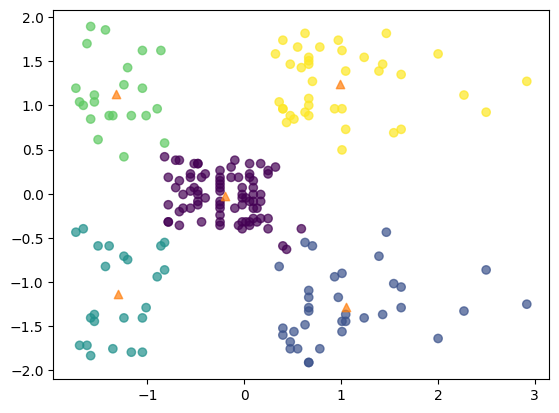

In [27]:
plt.scatter(X_scaled[variables[0]], X_scaled[variables[1]], c=labels, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', color='tab:orange', alpha=0.7)
plt.show()

##### K-means dla trzech zmiennych

<div class="alert alert-block alert-info">
📝 <b>Zadanie 5.1</b><br>
    Przygotujmy model K-means z liczbą klastrów równą 5, <b>wykorzystując wszystkie zmienne</b><br>
    Wykorzystajmy dane przeskalowane za pomocą StandardScalera.<br>
    Ustawmy ziarno losowości <i>random_state</i> na 42<br>
    Dokonajmy predykcji grup i znajdźmy centroidy klastrów.
</div>

In [28]:
model = KMeans(n_clusters=5, random_state=42, n_init='auto')
# auto żeby zlikwidować warning
model.fit(X_scaled)
labels = model.predict(X_scaled)
centroids = model.cluster_centers_

<div class="alert alert-block alert-info">
📝 <b>Zadanie 5.2</b><br>
    Zwizualizujmy wyniki klasteryzacji za pomocą wykresu punktowego.<br>
    Zaznaczmy na wykresie centroidy klastrów.<br>
</div>

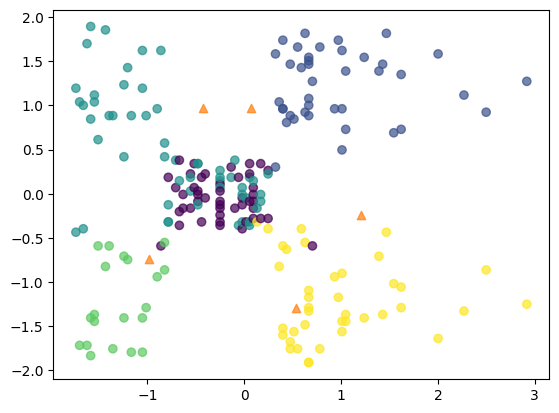

In [29]:
plt.scatter(X_scaled[variables[0]], X_scaled[variables[1]], c=labels, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', color='tab:orange', alpha=0.7)
plt.show()

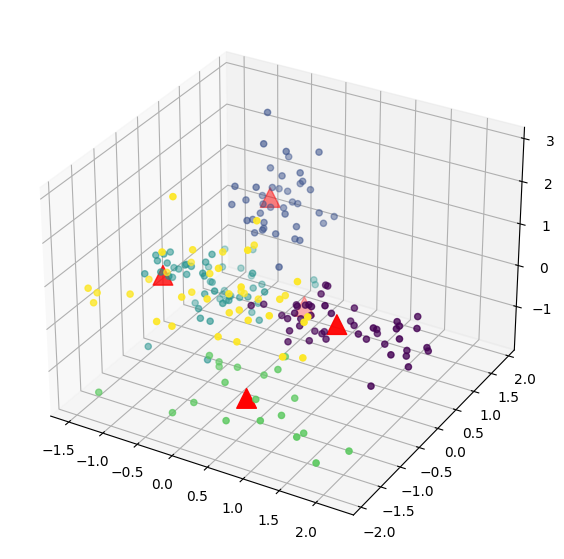

In [31]:
# variables = ['Age', 'Spending_score', 'Annual_income']
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_scaled[variables[0]],X_scaled[variables[1]],X_scaled[variables[2]], c=labels)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2], s=200, color="red", marker="^")

# Określenie liczby klastrów

<div class="alert alert-block alert-info">
    ❓ <b>Pytanie</b><br>
W jaki sposób możemy określić liczbę klastrów?</div>

## SSE i kryterium łokcia
Elbow Method

SSE - Sum of Squared Error - suma kwadratów odległości obserwacji wewnątrz klastra od jego centroidu

$ SSE = \sum_{i=1}^{K} \sum_{x\in C_i} (\mu _i - x)^2 $ <br><br>
gdzie:<br>
K - liczba klastrów <br>
$ \mu $ - centroid klastra *i*<br>

<div class="alert alert-block alert-info">
📝 <b>Zadanie 6</b><br>
    Korzystając z metody łokciowej (Elbow Method, SSE), znajdźmy optymalną liczbę klastrów w modelu K-means dla wszystkich zmiennych.<br>
    Weźmy pod uwagę maksymalnie 10 klastrów.<br>
    Przedstawmy wyniki SSE na wykresie liniowym. 
</div>

In [33]:
models = {}
sse = {}
max_clusters = 10
for k in range(1, max_clusters + 1):
    models[k] = KMeans(n_clusters=k, random_state=42, n_init='auto')
    models[k].fit(X_scaled)
    sse[k] = models[k].inertia_

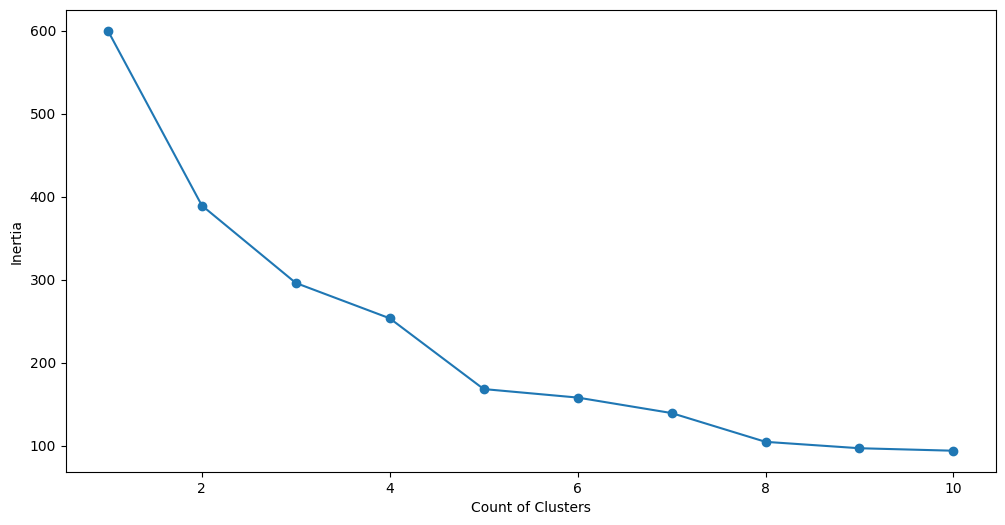

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Count of Clusters')
plt.ylabel('Inertia')
plt.show()

Wadą wewnątrz klastrowej sumy odległości (SSE) jest brak uwzględniania zróżnicowania między klastrami - brane pod uwagę jest jedynie wewnątrz klastrowe podobieństwo.

## Silhouette

Silhouette - sylwetka, współczynnik profilu - bierze pod uwagę średnie odległości między punktami wewnątrz klastra, a także średnią odległość do najbliższego klastra<br>

$S = {1 \over N} \sum_I s_I $<br><br>
gdzie:<br>
- $ s_I $ - <b style="color:#8a0022;">profil dla klastra  $C_I$ </b><br>
$ s_I = {b_i - a_i \over max(a_i, b_i)} $<br><br>
    - $a_i$ - <b style="color:#8a8a00;">spójność skupienia</b> - średnia odległość punktu $i$ do wszystkich innych punktów $j$ znajdujących się w klastrze $C_i$. Określa <b>jednorodność wewnątrz klastra</b><br>
$ a_i = {1 \over |C_I| - 1} \sum_{j\in C_i, i \neq j} d(i, j) $ <br>
        - $ |C_I| $ - liczba punktów należących do klastra $i$<br><br>
    - $b_i$ - <b style="color:DarkCyan;">odstęp skupienia</b> - średnia odległość punktu $i$ do wszystkich punktów $k$ w następnym najbliższym klastrze $C_K$. Określa **zróżnicowanie między klastrami**<br>
$ b_i = min_{K \neq I} {1 \over |C_K|} \sum_{j\in C_K} d(i, k) $ <br>
        - $C_K$ - najbliższy następny klaster

Schemat obliczania współczynnika profilu:
<ol>
<li>Oblicz <b style="color:#8a8a00;">spójność skupienia $a_i$</b> jako średnią odległość pomiędzy obserwacją $x_i$ <u>a wszystkimi pozostałymi elementami skupienia</u> </li>
<li>Oblicz <b style="color:DarkCyan;">odstęp skupienia $b_i$</b> od najbliższego sąsiadującego skupienia jako średnią odległość pomiędzy obserwacją $x_i$ <u>a wszystkimi przykładami należącymi do sąsiadującej grupy</u></li>
<li>Oblicz <b style="color:#8a0022;">profil $s_I$</b> jako różnicę pomiędzy spójnością skupienia a jego odstępem, dzieloną przez większą wartość jednego z tych dwóch parametrów</li>
</ol>

Wartości Silhouette dla każdego klastra mieszczą się przedziale [-1, 1]<br>
$ -1 \le s_I \le 1 $<br><br>
Wartości $s_I$ bliskie:
- $1$ wskazują, że punkt $i$ znajduje się wewnątrz swojego skupienia i daleko od innych grup
- $0$ wskazują, że punkt $i$ znajduje się na granicy klastrów
- $-1$ wskazują, że punkt $i$ powinno być przypisane do innego klastra

Im większa wartość $S$ (a także $s_I$), tym lepiej.

<div class="alert alert-block alert-info">
📝 <b>Zadanie 7</b><br>
    Korzystając z metody Silhouette, znajdźmy optymalną liczbę klastrów w modelu K-means dla wszystkich zmiennych.<br>
    Weźmy pod uwagę maksymalnie 10 klastrów.<br>
    Przedstawmy wyniki SSE na wykresie liniowym. 
</div>

<div class="alert alert-block alert-danger">
❗️<b>Uwaga</b><br>
Funkcja silhouette_score wymaga co najmniej dwóch klastrów.</div>

In [ ]:
# new one
# max_clusters = 10
# silhouette = {}

# for k in range(2, max_clusters+1):
#     model = KMeans(n_clusters=k, n_init='auto', random_state=42)
#     model.fit(X_scaled)
#     labels = model.predict(X_scaled)
#     silhouette[k] = silhouette_score(X=X_scaled, labels=labels)

In [37]:
from sklearn.metrics import silhouette_score


silhouette = {}
for k in models.keys():
    labels = models[k].predict(X_scaled)
    nunique_labels = len(set(labels))
    if nunique_labels > 1:
        silhouette[k] = silhouette_score(X=X_scaled, labels=labels)

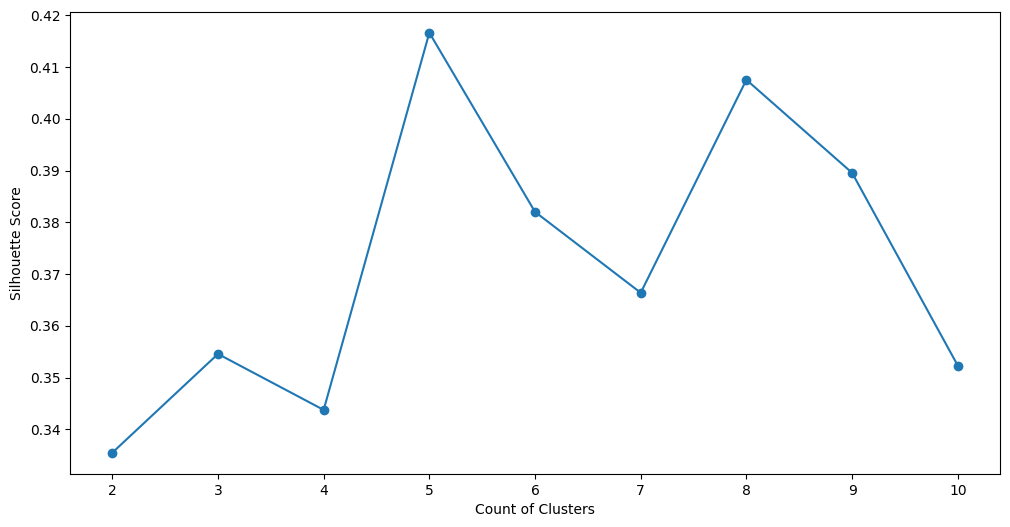

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(list(silhouette.keys()), list(silhouette.values()), marker='o')
plt.xlabel('Count of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [39]:
n_clusters = pd.Series(silhouette).idxmax()
n_clusters

5

<div class="alert alert-block alert-info">
📝 <b>* Zadanie</b><br>
    Zwizualizujmy wartości Silhouette.<br>
    Wykorzystajmy modele K-means dla dwóch zmiennych: Annual_income i Spending_score
</div>


https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
from sklearn.metrics import silhouette_samples, silhouette_score


# Below function is based on the code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def get_sihouette_plot(model, data):
    n_clusters = model.n_clusters
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Get cluster labels
    cluster_labels = model.predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    colors = []
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        colors.append(color)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for each cluster.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='.', s=150, alpha=0.6, c=colors)

    # Label the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=0.5, s=300, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.annotate(str(i), (c[0], c[1]), ha='center', va='center')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("1st feature")
    ax2.set_ylabel("2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  f"with n_clusters = {n_clusters}"),
                 fontsize=14, fontweight='bold')

    plt.show()

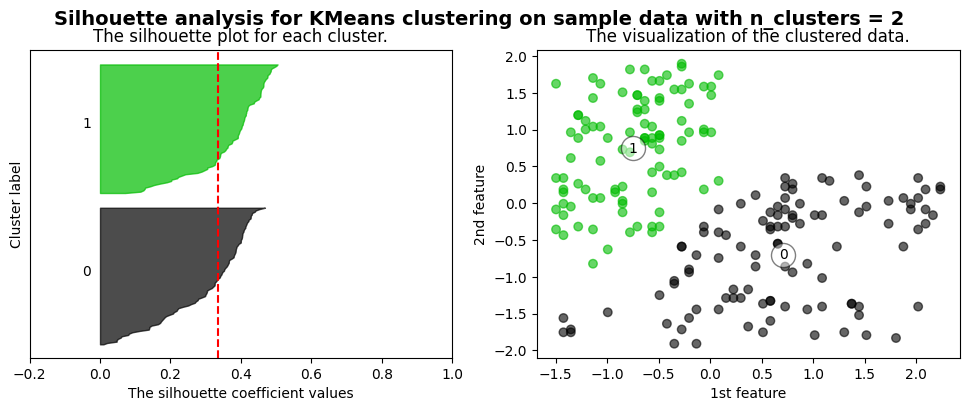

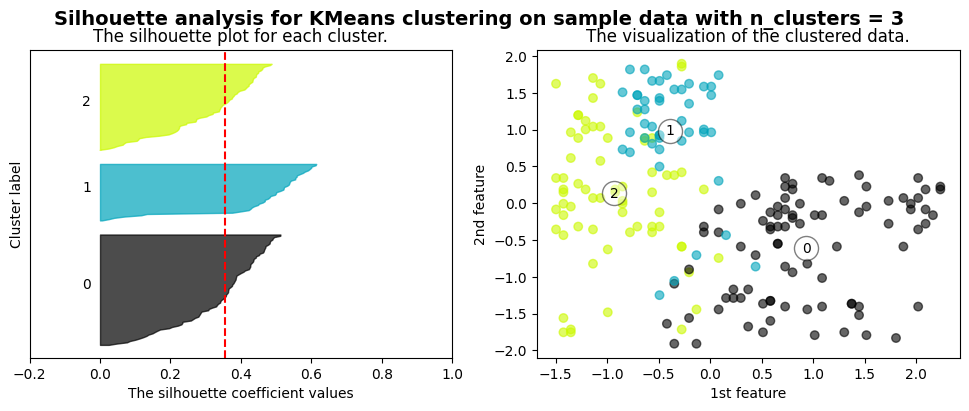

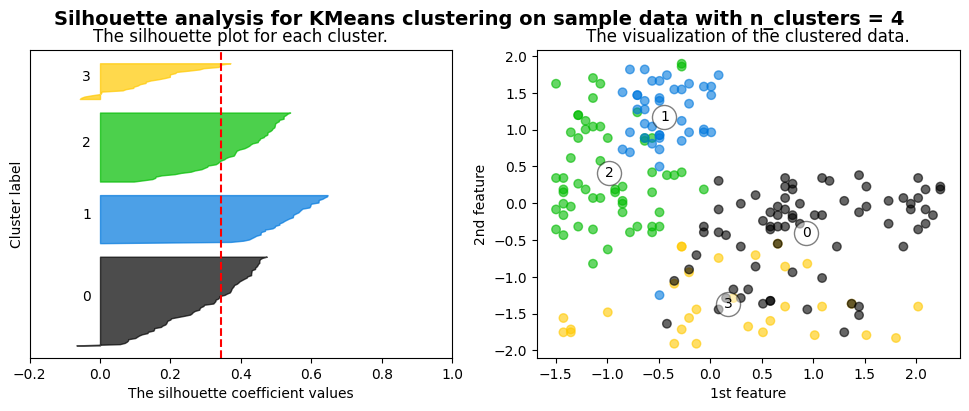

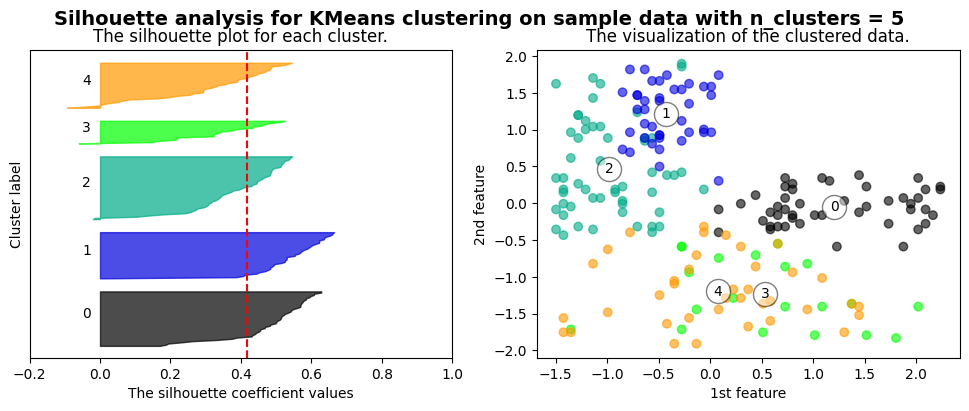

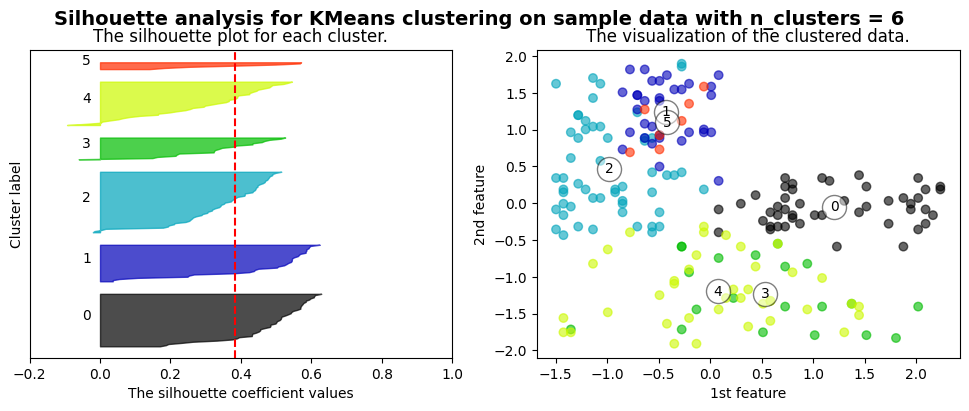

In [42]:
max_clusters = 6
for k in range(2, max_clusters + 1):
    km_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km_model.fit(X_scaled[variables])
    get_sihouette_plot(model=km_model, data=X_scaled[variables])

## Davies Bouldin Score

Davies–Bouldin index
- bazuje na stosunku pomiędzy podobieństwem wewnątrz klastrowym i zewnątrz klastrowym
- to średnia maksymalnego stosunku między odległością punktu od centroidu jego grupy a odległością między dwoma centroidami grup
- porównuje średni dystans pomiędzy każdym punktem w klastrze, a jego *centroidem*
- im mniejsza wartość tym lepiej (przyjmuje wartości od zera do nieskończoności)

<div class="alert alert-block alert-info">
📝 <b>Zadanie</b><br>
    Korzystając z metody Davies-Bouldin Index, znajdźmy optymalną liczbę klastrów w modelu K-means dla wszystkich zmiennych.<br>
    Weźmy pod uwagę maksymalnie 10 klastrów.<br>
    Przedstawmy wyniki Davies-Bouldin Score na wykresie liniowym. 
</div>

In [43]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin = {}
for k in models.keys():
    labels = models[k].predict(X_scaled)
    nunique_labels = len(set(labels))
    if nunique_labels > 1:
        davies_bouldin[k] = davies_bouldin_score(X=X_scaled, labels=labels)

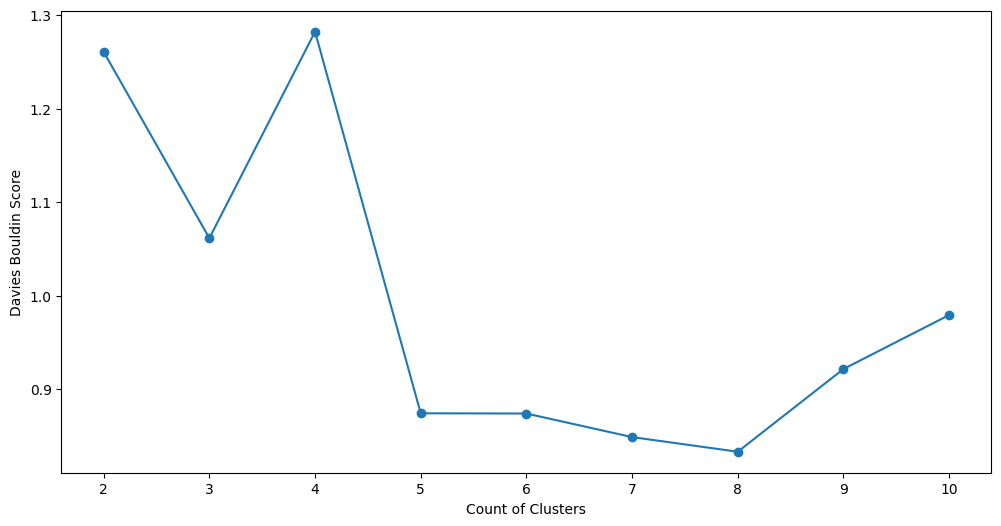

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(list(davies_bouldin.keys()), list(davies_bouldin.values()), marker='o')
plt.xlabel('Count of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

In [46]:
n_clusters = pd.Series(davies_bouldin).idxmin()
n_clusters

8

# Analiza skupień c.d.

## Model mieszaniny gaussowskiej

<div class="alert alert-block alert-success">
📍<b>Model mieszaniny gaussowskiej</b> - Gaussian Mixture Model - GMM<br>
    Zakłada, że klastry są reprezentowane przez rozkład Gaussa z nieznanymi parametrami.<br>
    GMM pozwala oszacować prawdopodobieństwa, z jakim każda obserwacja pochodzi z danego rozkładu<br>
    Wykorzystuje algorytm Expectation-Amximization (EM) w celu określenia parametrów GMM.<br>
    
    
Kryterium zbieżności modelu jest określony za pomocą algorytmu Expectation-Amximization (EM)<br>
<ul>
    <li>μ - wektor średnich</li>
    <li>∑ - macierz kowairancji o wymiarach DxD</li>
    <li>π - wagi (prawdopodobieństwa przynależności obserwacji do grupy)</li>
</ul><br>
    Initialize μ, ∑, and mixing coefficient π and evaluate the initial value of the log likelihood L
Evaluate the responsibility function using current parameters
Obtain new μ, ∑, and π using newly obtained responsibilities
Compute the log likelihood L again. Repeat steps 2–3 until the convergence.
    <ol>
    <li>Algorytm inicjalizuje parametry rozkładów (μ, ∑) losowo i liczona jest funkcja wiarygodności L.</li>
    <li><b>[Faza oczekiwania (Expectation)]:</b> Aktualizujemy przypisania obserwacji do skupień</li>
        Dla każdej obserwacji szacowane jest <u>prawdopodobieństwo π</u> przynależności do każgej grupy na podstawie aktualnych parametrów rozkładu.
    <li><b>[Faza maksymalizacji (Maximization)]:</b> Aktualizujemy parametry rozkładów</li>
        Aktualizujemy parametry rozkładów (μ, ∑) wykorzystując wszystkie obserwacje z wagami π odpowiadającymi prawdopodobieństwom przynależności do grupy. Obliczamy funkcję wiarygodności L.
    <li>Punkty 2. i 3. (EM) są powtarzane do osiągnięcia zbieżności</li>
</ol>
EM jest uogólnieniem algorytmu K-Means, określający nie tylko centra skupień (μ - wektor średnich), ale również kształty, rozmiary i kierunki (∑ - macierz kowairancji), a także względne wagi (phi)
    
</div>

https://sandipanweb.wordpress.com/2017/03/19/hard-soft-clustering-with-k-means-weighted-k-means-and-gmm-em/
![GMM](https://sandipanweb.files.wordpress.com/2017/03/gmmem7.gif)

<div class="alert alert-block alert-info">
📝 <b>Zadanie 9.1</b><br>
    Przygotujmy model Mieszaniny Gaussowskiej z liczbą komponentów (<i>n_components</i>) równą 6.<br>
    Wykorzystajmy wszystkie zmienne przeskalowane za pomocą StandardScalera.<br>
    Ustawmy ziarno losowości <i>random_state</i> na 42<br>
    Dokonajmy predykcji grup.
</div>

In [47]:
from sklearn.mixture import GaussianMixture

In [48]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)
labels[:10]

array([3, 2, 3, 2, 3, 2, 3, 2, 3, 2], dtype=int64)

<div class="alert alert-block alert-danger">
    ❗️W modelach mieszaniny Gaussowskiej, nie otrzymujemy centroidów, ale możemy określić prawdopodobieństwo, z jakim punkty należą do danego klastra.</div>

Wykorzystajmy prawdopodobieństwa przynależności do grup w wizualizacjach jako rozmiar punktów

In [49]:
labels_proba = gmm.predict_proba(X_scaled)
labels_proba[:3]
# prawdopodobiensta przynależności do poszczególnych klatrów

array([[5.97174961e-08, 2.34194741e-21, 6.97626573e-05, 9.99930175e-01,
        2.26779288e-09, 3.40754836e-19],
       [1.76651802e-13, 7.60689302e-21, 9.99995494e-01, 4.50596316e-06,
        5.68198809e-24, 7.47445917e-52],
       [3.08082062e-18, 3.96632435e-26, 4.90486148e-13, 9.99846853e-01,
        1.53147226e-04, 3.17538904e-17]])

In [53]:
df = pd.DataFrame(labels_proba)
df

,0,1,2,3,4,5
0,5.971750e-08,2.341947e-21,6.976266e-05,9.999302e-01,2.267793e-09,3.407548e-19
1,1.766518e-13,7.606893e-21,9.999955e-01,4.505963e-06,5.681988e-24,7.474459e-52
2,3.080821e-18,3.966324e-26,4.904861e-13,9.998469e-01,1.531472e-04,3.175389e-17
3,1.381612e-11,1.233988e-18,9.999799e-01,2.010675e-05,8.131502e-22,2.494745e-40
4,4.372316e-06,4.458306e-14,6.492805e-04,9.993463e-01,2.738162e-08,2.015740e-09
...,...,...,...,...,...,...
195,1.431073e-22,2.467537e-06,4.449873e-21,2.363718e-34,1.031363e-10,9.999975e-01
196,1.580468e-14,1.321438e-24,4.408103e-13,2.011538e-40,1.000000e+00,4.665704e-73
197,4.361592e-23,8.720843e-08,8.963112e-21,2.540724e-39,2.342209e-09,9.999999e-01
198,1.100467e-19,1.369821e-25,1.285842e-08,1.113051e-54,1.000000e+00,8.803095e-48


In [50]:
labels_proba.max(axis=1)[:10]

array([0.99993018, 0.99999549, 0.99984685, 0.99997989, 0.99934632,
       0.99995376, 0.99973368, 0.99999997, 0.9998884 , 0.99982487])

<div class="alert alert-block alert-info">
📝 <b>Zadanie 9.2</b><br>
    Zwizualizujmy wyniki klasteryzacji za pomocą wykresu punktowego.<br>
</div>

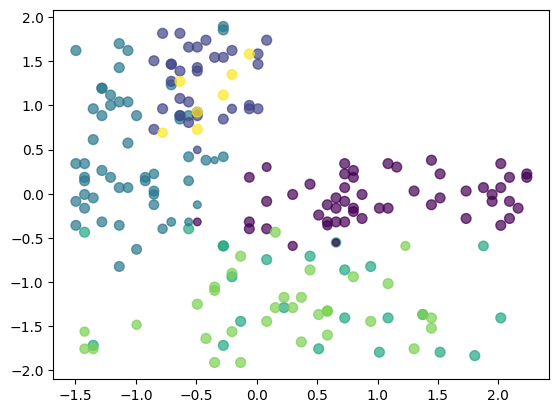

In [55]:
plt.scatter(X_scaled[variables[0]], X_scaled[variables[1]], c=labels, s=labels_proba.max(axis=1)*50, alpha=0.7)
plt.show()

## DBSCAN

<div class="alert alert-block alert-success">
📍<b>DBSCAN</b> - Density-Based Spatial Clustering of Applications with Noise<br>
    To algorytm oparty na gęstości obserwacji w przestrzeni. Skupieniami są obszary o dużej gęstości.<br>
    
    
Podstawowe parametry:
<ul>
    <li><code>epsilon</code> - ($\varepsilon$) - promień sąsiedztwa, czyli maksymalna odległość między dwoma obserwacjami, niezbędna do uznania ich jako sąsiadów</li>
    <li><code>min_samples</code> - minimalna liczba obserwacji, potrzebna do utworzenia skupienia</li>
</ul>
    
Mechanizm działania:
<ul>
    <li>Dla każdego punktu algorytm zlicza liczbę obserwacji znajdujących się w promieniu $\varepsilon$ od niego.</li>
    <li>Obserwacje, które w sąsiedztwie $\varepsilon$ posiadają co najmniej <code>min_samples</code> sąsiadów są określane jako obserwacje rdzeniowa (core instance)</li>
    <li>Wszystkie obserwacje w sąsiedztwie rdzenia są przypisywane do tego samego skupienia. Jeśli w sąsiedztwie znajduje sie kilka obserwacji rdzeniowych, to nasze skupienie poszerza się o te obserwacje i obserwacje w ich sąsiedztwie (obserwacje graniczne), tworząc dłuższe sekwencje.</li>
    <li>Obserwacje, które nie załapały się do żadnego skupienia, są uznawane za anomalie</li>
</ul>
    
Algorytm działa dobrze, jesli skupienia są wystarczająco gęste i gdy są rozdzielone obszarami o małym zagęszczeniu
</div>

https://medium.com/analytics-vidhya/cluster-analysis-with-dbscan-density-based-spatial-clustering-of-applications-with-noise-6ade1ec23555 <br>
![DBSCAN](https://miro.medium.com/max/640/1*WBRWZwSeIw-V4Hw9-_0xrQ.gif)

<div class="alert alert-block alert-info">
📝 <b>Zadanie 10.1</b><br>
    Przygotujmy model DBSCAN z parametrami:
    <ul>
    <li>epsilon: <code>eps=0.4</code> </li>
    <li>min_samples: <code>min_samples=4</code></li>
</ul>
    Wykorzystajmy <b>tylko dwie zmienne</b>: <i>'Annual_income'</i> i <i>'Spending_score'</i>, przeskalowane za pomocą StandardScalera.<br>
</div>

In [56]:
from sklearn.cluster import DBSCAN

variables = ['Annual_income', 'Spending_score']
db = DBSCAN(eps=0.4, min_samples=4)
db.fit(X_scaled[variables])

DBSCAN(eps=0.4, min_samples=4)

In [68]:
pd.Series(db.labels_).value_counts()
# -1 = nie należą do klastra, są to anomalie

 0    126
 1     33
 2     27
-1     14
dtype: int64

<div class="alert alert-block alert-info">
📝 <b>Zadanie 10.2</b><br>
    Zwizualizujmy wyniki klasteryzacji za pomocą wykresu punktowego.<br>
</div>

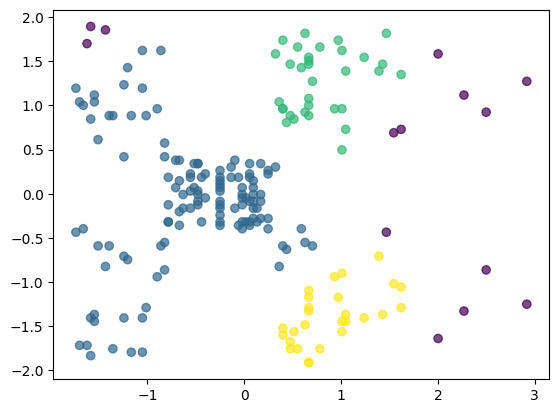

In [69]:
plt.scatter(X_scaled[variables[0]], X_scaled[variables[1]], c=db.labels_, alpha=0.7)
plt.show()

## Klasteryzacja hierarchiczna

<div class="alert alert-block alert-success">
📍 <b>Aglomeracyjna klasteryzacja hierarchiczna</b><br>
    Początkowo każdą obserwację traktujemy jako osobne skupienie i stopniowo dążymy do łączenia par najbliższych elementów, aż do uzyskania jednego zbiorczego skupienia.<br><br>

Schemat aglomeracyjnej klasteryzacji hierarchicznej:
<ol>
    <li>Obliczenie macierzy odległości dla wszystkich przykładów</li>
    <li>Utworzenie poczatkowych skupień reprezentowanych przez pojedyncze obserwacje</li>
    <li>Połączenie dwóch najbliższych skupień bazując na wybranej metodzie wiązania:</li>
    <ul>
        <li>Pojedyncze wiązanie (najbliższe sąsiedztwo, single linkage)</li>
        Odległość między dwoma klastrami jest <b>minimalną</b> odległością między obserwacją w jednym klastrze a obserwacją w innym klastrze.
        <li>Pełne wiązanie (najdalsze sąsiedztwo, complete linkage)</li>
        Odległość między dwoma klastrami jest <b>maksymalną</b> odległością między obserwacją w jednym klastrze a obserwacją w innym klastrze.<br>
        W algorytmie pełnego wiązania, najbliższe skupienia to te, których odległość miedzy dwoma najbardziej różniącymi się elementami jest najmniejsza.
    </ul><br>
    <li>Aktualizacja macierzy podobieństwa (macierz odległości)</li>
    <li>Powtarzamy kroki 2.-4., dopóki nie pozostanie tylko jedno skupienie</li>
    </ol>
</div>

  <span style="color:#707070;">Deglomeracyjna klasteryzacja hierarchiczna - odwrotna do aglomeracyjnej; zaczynamy od skupienia zawierającego wszystkie obserwacje i dzielimy go  na mniejsze grupy, aż do momentu, gdy każda obserwacja stanowi osobne skupienie. My zajmiemy klasteryzacją się aglomeracyjną.</span><br>

<div class="alert alert-block alert-info">
📝 <b>Zadanie 11.1</b><br>
    Przygotujmy model aglomeracyjnej klasteryzacji hierarchicznej z liczbą klastrów (<i>n_components</i>) równą 5.<br>
    Wykorzystajmy <b>tylko dwie zmienne</b>: <i>'Annual_income'</i> i <i>'Spending_score'</i>, przeskalowane za pomocą StandardScalera.<br>
    Dokonajmy predykcji grup.
</div>

In [70]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram


agg_model = AgglomerativeClustering(linkage="complete", n_clusters=5)
agg_model.fit(X_scaled[variables])
labels = agg_model.labels_

In [73]:
labels

array([1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0], dtype=int64)

<div class="alert alert-block alert-info">
📝 <b>Zadanie 11.2</b><br>
    Zwizualizujmy wyniki klasteryzacji za pomocą wykresu punktowego.<br>
</div>

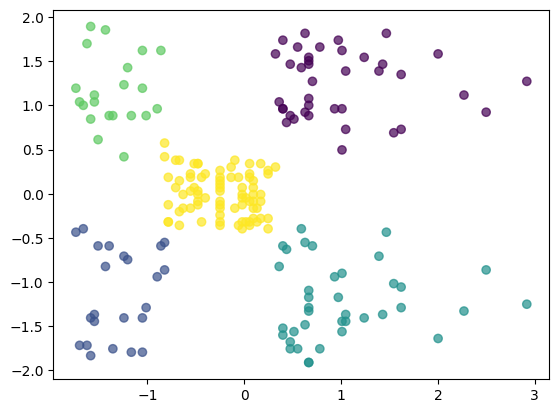

In [71]:
plt.scatter(X_scaled[variables[0]], X_scaled[variables[1]], c=labels, alpha=0.7)
plt.show()

<div class="alert alert-block alert-info">
📝 <b>Zadanie 11.3</b><br>
    Przygotujmy graficzną reprezentację dendrogramu.<br>
</div>

<div class="alert alert-block alert-warning">
📍 Dendrogram - graficzne przedstawienie hierarchicznej analizy skupień. 
</div>

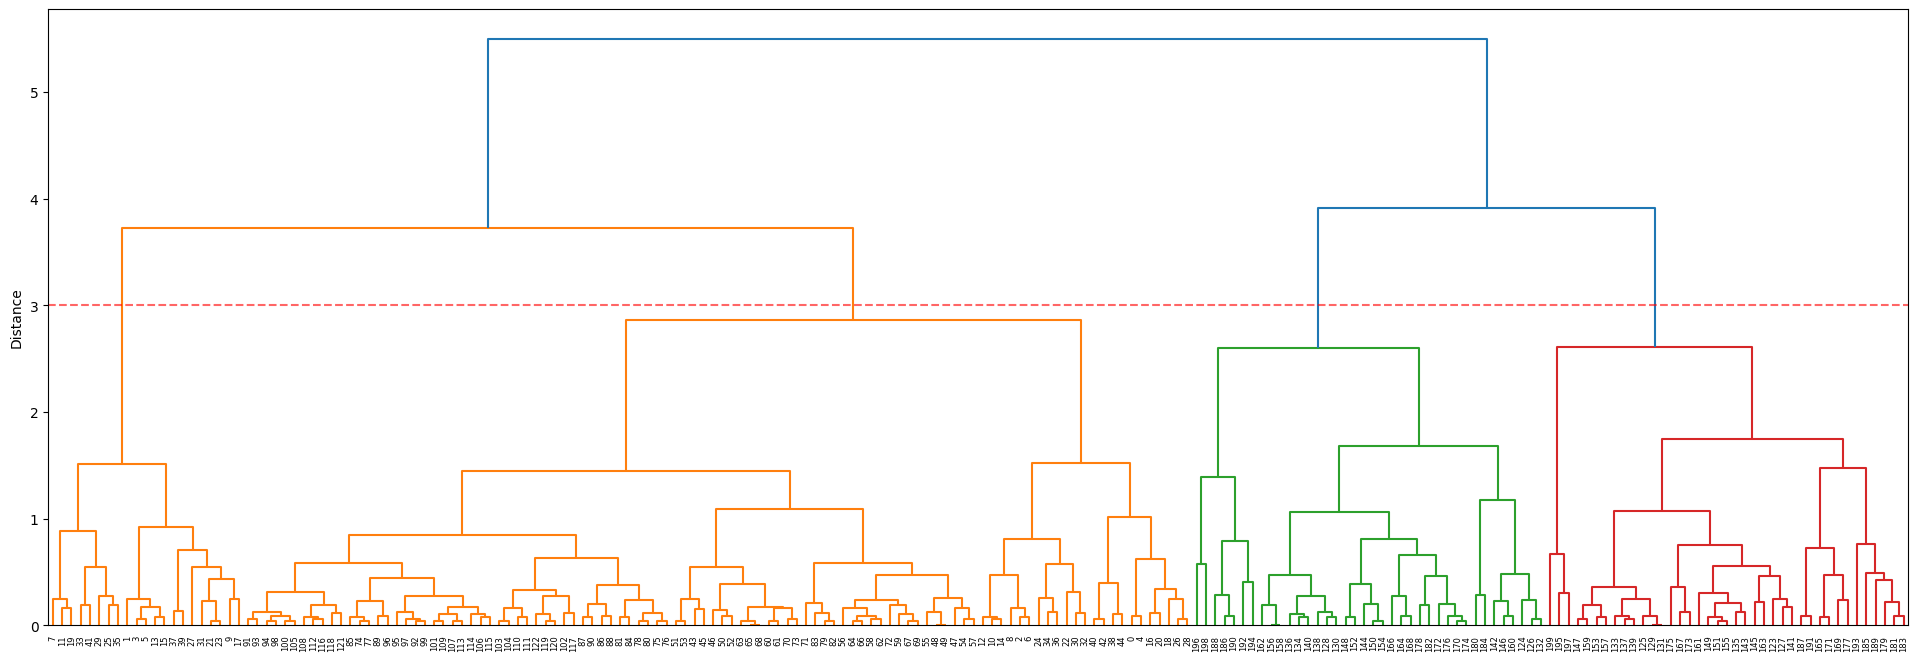

In [75]:
mergings = linkage(X_scaled[variables], method='complete')

plt.figure(figsize=(24,8))
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6)
# plt.axhline(y=5, color='r', linestyle='--')
# plt.axhline(y=4, color='r', linestyle='--', alpha=0.8)
# plt.axhline(y=3, color='r', linestyle='--', alpha=0.6)
# plt.axhline(y=2, color='r', linestyle='--', alpha=0.5)
# plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
plt.ylabel('Distance')
plt.show()
# mniejsze pionowe kreski, większe zbliżenie klastrów

# Pipeline

Możemy zautomatyzować modelowanie wykorzystując funkcję tworzącą przepływ (make_pipeline). Dzięki temu preprocessing i klasteryzacja będą następowały po sobie automatycznie.<br>
Zróbmy to na przykładzie StandarcScalera i modelu K-Means

<div class="alert alert-block alert-info">
📝 <b>Zadanie 12</b><br>
    Przygotujmy przepływ (pipeline) łączący skalowanie danych za pomocą MinMaxScalera i model K-means.
</div>

In [78]:
from sklearn.pipeline import make_pipeline

scaler = MinMaxScaler()
model = KMeans(n_clusters=5, random_state=42, n_init='auto')
# kroki jakie chce, zeby byly wykonane
pipeline = make_pipeline(scaler, model)
pipeline.fit(df) # df - dane wejściowe
labels = pipeline.predict(df)

In [79]:
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])